<a href="https://colab.research.google.com/github/aryanfaghihi/ai-course/blob/master/Image%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Make a copy

**Follow the following steps to make your own copy. You will lose your changes if you don't make your own copy!**

From the tooltip above, you should see 

File | Edit | View | Insert | Runtime | Tools | Help

1. Click on **File**
2. Click on **Save a copy in Drive**

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from google.colab import files

# Data

So far, we've doing classification which is recognising an object in an image. Today though, we will be doing **segmentation** which includes classifying every single pixel in an image! Sounds cool right? 

We will be using the `CAMVID` dataset today which includes labeled driving data. An example of the dataset is shown below.

![](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/pr/DBOverview1_1_huff_0000964.jpg)

> Today we will train a model that is able to classify every single pixel on the image as shown in the image above.

## Looking at data

Let's first start by downloading the dataset.

In [ ]:
# download and extract the dataset
path = untar_data(URLs.CAMVID)

This dataset is slightlty more complex and we should look at the structure of it before continuing.

In [ ]:
# view the dataset structure
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

Let's define a variable for each folder and file that we see here.

In [ ]:
# get a reference to each path
images_path = path/'images'
labels_path = path/'labels'
valid_path = path/'valid.txt'
codes_path = path/'codes.txt'

Just a side note on what each folder contains
* `/images` a list of training images
* `/labels` a list of label images (notice that the labels are now images because the output of our model is no longer just object names, it's actually an image with different colours for different objects)
* `valid.txt` this file contains a list of filenames to be used for the validation dataset
* `codes.txt` this file contains the name of each object for our labels

Ok, let's look at some images from the `/images` folder

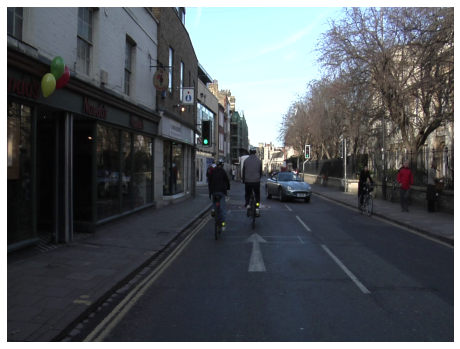

In [ ]:
# read the name of the images files
images = get_image_files(images_path)

# select an image
img = images[0]

# read and display the image
open_image(img).show(figsize=(8,8))

Now that we know what the training images look like, let's have a look at our label images

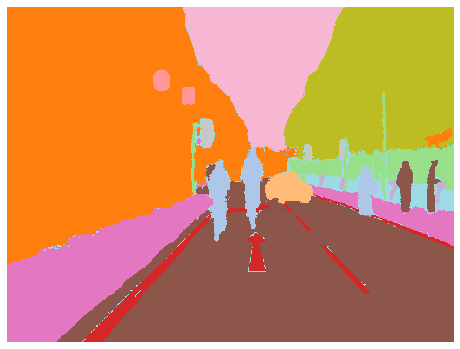

In [ ]:
# define a lambda function to select the label correspoding to a training image
get_label = lambda x: labels_path/f'{x.stem}_P{x.suffix}'

# select the label
label = get_label(img)

# display the label with mask
open_mask(label).show(figsize=(8,8), alpha=1)

Don't worry too much about what these functions are actually doing here. The key point is that each pixel on this image has a different colour which is associated with a different classification.

> We know what each pixel in the image represents.

---

Can you think of an example where **segmentation** like the one shown above can be very useful?

---

Lastly, let's also look at the `codes.txt` file which includes all the possible segmentation objects that have been labelled in our dataset.

In [ ]:
# read the codes.txt using numpy
codes = np.loadtxt(codes_path, dtype=str)

# print codes
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Dataloader

Time to define our good friend `dataloader` using the following syntax. Hopefully you can recognise some of these functions from the previous sections. It is not super important to know the syntax but it is important to know high-level what each of these methods are doing.

In [ ]:
data = SegmentationItemList.from_folder(images_path) \
                            .split_by_fname_file(valid_path) \
                            .label_from_func(get_label, classes=codes) \
                            .transform(get_transforms(), size=np.array([360, 480]), tfm_y=True) \
                            .databunch(bs=8) \
                            .normalize(imagenet_stats)

An advanced note on what each method is doing
* `from_folder` retrieves a list of all traning images
* `split_by_fname_file` split training and validation set based on the filenames listed in `valid_path`
* `label_from_func` grab the labels for images using the `get_label` function defined earlier
* `transform` apply the default transformations using `get_transforms()` function
* `databunch` create the dataloader from the options described earlier
* `normalize` normalize the images to reduce spread in our values which helps training the model later on 

Now let's view a batch of our training data!

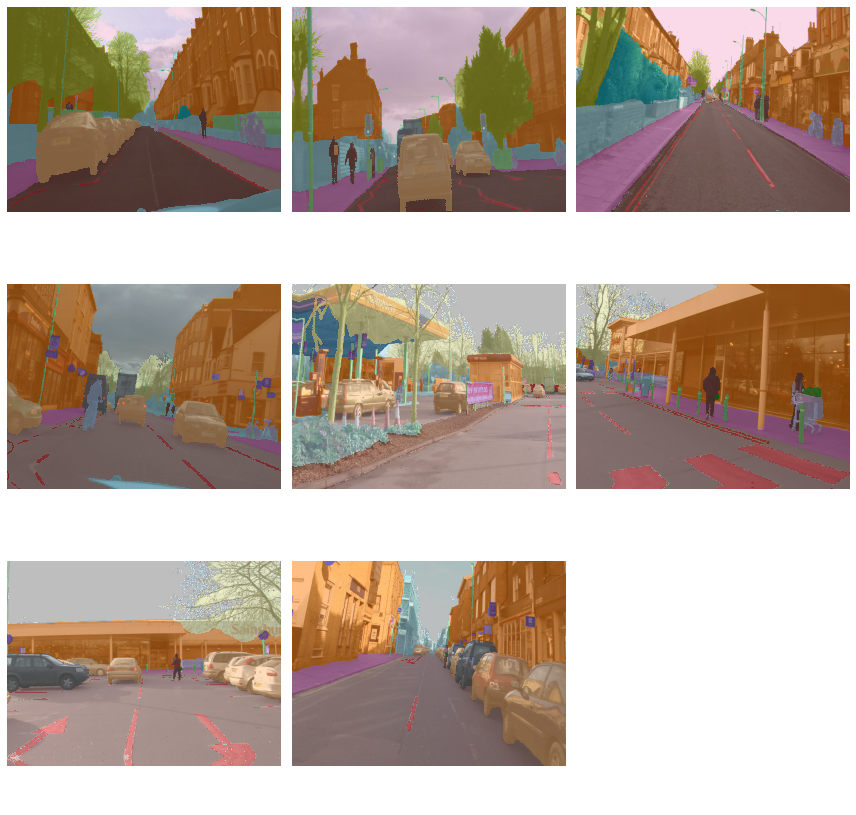

In [ ]:
# use the show_batch() method to display a batch of images
## YOUR CODE HERE

data.show_batch()

Awesome! we are now ready to train our model.

# Model

We can finally a train a model that outputs **segmentation** of an image.

## Training

First, we need to define a *custom loss function*. So far, we've been working with standard data types. Therefore it has been quite easy for `fastai` to figure how to calculate the loss. 

In this case though, we need to write code to define how this loss function should work.

You don't need to know how this works but you are more than welcome to try and decode what each line means.

In [ ]:
## ADVANCED LOSS FUNCTION
## YOU DON'T NEED TO KNOW HOW THIS WORK
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Next, we can define our `learner`. But wait, we are learning something completely new. It would make sense for the structure of our learner to be different, and it is different. We are using a **U-Net** here. 

Why is it called **U-Net** you may ask? Well it's because the architecture of the network actually looks like a **U**.

![](https://fastai1.fast.ai/imgs/u-net-architecture.png)

Understand how **U-Net** works is well beyond the scope of this course but here's a few key points:
* It uses CNNs to extract important features/patterns from the image
* While extracting features it also downsamples to reduce the size of these features. Why? to simply learn the most important features over time.
* Once you reach the bottom, you've extracted the most important features/patterns in your image
* We then start to up-sample to generate an image!
* There are these things called a **skip-connection** that connect the left and right side of a U-Net to be able to regenerate the image. 

In summary
> U-Net learns the most important features of the image and then regenerates a new image with the properties you are interested in (such as segmentation).

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2, callback_fns=ShowGraph)

You might notice that the only thing different from `cnn_learner` and `unet_learner` is simply the metrics input. But that's because `fastai` has abstracted away all the complexities. These models are actually quite complicated!

epoch,train_loss,valid_loss,acc_camvid,time
0,1.566256,1.489904,0.645468,01:26
1,2.324676,1.593237,0.543891,01:20
2,1.395432,1.077876,0.698840,01:21
3,0.987687,0.893964,0.775970,01:21


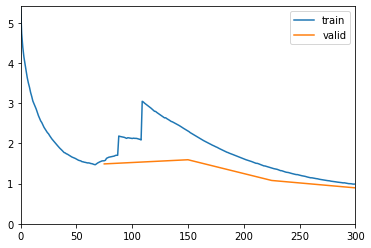

In [ ]:
# start training the model
learn.fit_one_cycle(4)

Feel free to rerun this cell while changing the number of `epochs` to get better `acc_camvid` which is basically how accurate your model is.

## Interpretation


Time to objectively assess how are our model is performing.

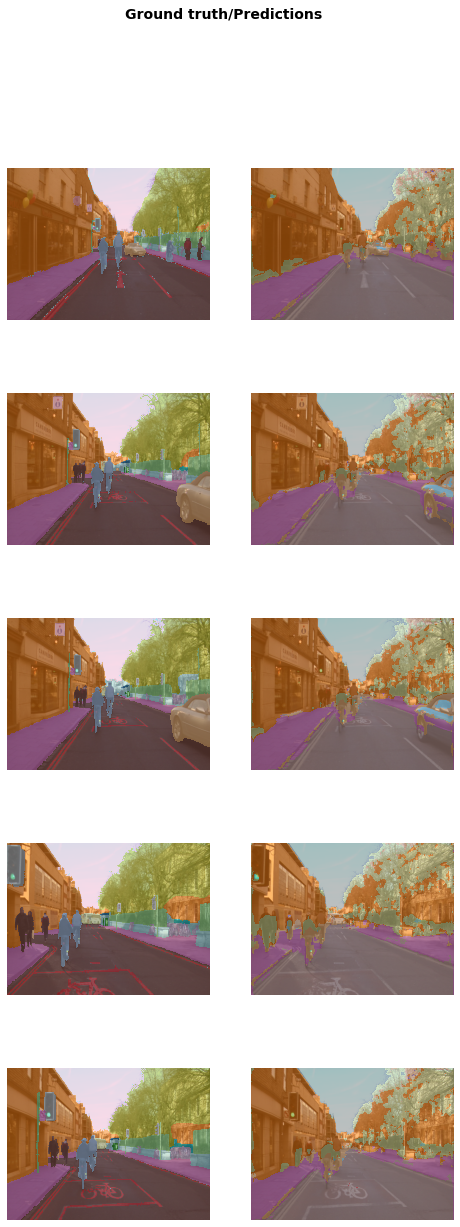

In [ ]:
learn.show_results()

## Testing

Now is your chance to assess the performance of the model using your own examples.

Run the following and cell and select your own image. You'd want to choose an image of driving in a car from the driver's persepective.

Saving drive.png to drive (1).png


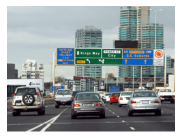

In [ ]:
# upload a new image
uploaded = files.upload()

# grab the name of the uploaded image
filename = list(uploaded)[0]

# open the image
image = open_image(filename)

# view the image
show_image(image);

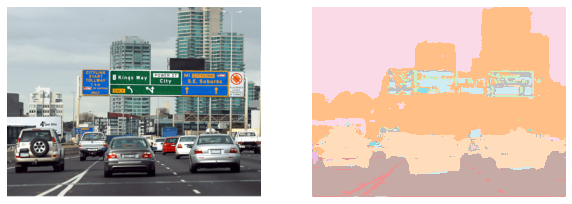

In [ ]:
# pass it through the model to get the segmentation
segmented_img = learn.predict(image)[0]

# view the original and segmented image
_, axs = plt.subplots(1, 2, figsize=(10,10))
image.show(ax=axs[0])
segmented_img.show(ax=axs[1])

## Fine-tuning

Going a step further. As done in the previous notebook, we can `unfreeze` the model and slowly improve the entire model.

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


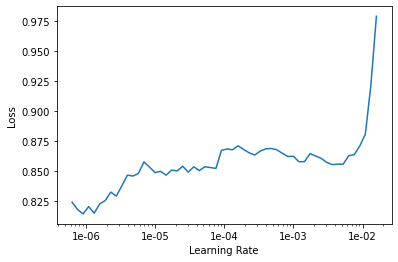

In [ ]:
# find the appropriate learning rate
lr_find(learn)

# plot losses vs learning rate
learn.recorder.plot() 

**You'd want to choose a range from where the model has not gone exponentially high**. This is where the model can learn new information without exponentially increasing its loss (which in turn reduces the accuracy)

In [ ]:
# unfreeze the modeel
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.823722,0.836791,0.800213,01:23
1,0.776381,0.797254,0.809991,01:24


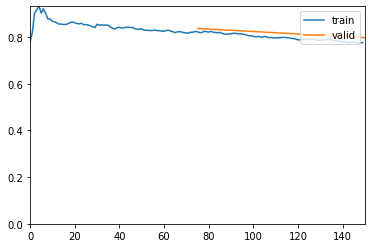

In [ ]:
# start fine-tuning the model
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

You should see a slight increase in accuracy. If not, you might have reached the point where your model cannot improve anymore. 

Once you are done training here, you can scroll back above to the *Testing* section and try out your model with your own images again! and continue this process until you get a model that you are happy with.

A lot of Deep Learning is experimentation, people spend weeks experimenting with different learning rates and datasets to get the best possible model so don't feel you have to get it perfect the first time.

# Summary

* We learnt about segmentation and how it differs from classification
* How to define dataloader for segmentation data
* Model architecture for segmentation
* How to fine-tune our tranining using `unfreeze()`